In [1]:
import sys
sys.path.append('../')
from lib.matrix_approach.layers import *
%load_ext autoreload
%autoreload 2

import flappy_bird_gymnasium
import gymnasium as gym
import numpy as np
import random
from IPython import display, embed
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

In [2]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32
n_episodes = 1000

In [3]:
class NN(Network):
    def __init__(self):
        self.layers = [
            FC(state_size, 24),
            ReLU(),
            FC(24, 24),
            ReLU(),
            FC(24, action_size),
        ]

    def __call__(self, inputs):
        input = np.array(inputs)
        return self.forward(input)

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size, model):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)

        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0
        # self.epsilon_decay = 0.995
        self.epsilon_decay = 1.0/n_episodes
        self.epsilon_min = 0.01

        self.learning_rate = 0.0001
        self.model = model
        self.loss_fn = MSE()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, eval=False):
        if not eval and np.random.rand() <= self.epsilon:
            # return random.randrange(self.action_size)
            return random.choices([0,1], weights=[90, 10])[0]
        act_values = self.model([state])
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                outputs = self.model([next_state])
                target = reward + self.gamma * np.amax(outputs, axis=1)[0]

            output = self.model([state])

            target_output = np.copy(output)
            target_output[0][action] = target

            loss = self.loss_fn(output, target_output)
            self.model.backward(self.loss_fn)

            # Update weights
            params, grads = self.model.parameters()
            updated_params = params + -1 * self.learning_rate * grads
            self.model.set_parameters(updated_params)

        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
            # self.epsilon *= self.epsilon_decay

In [5]:
def eval(env, agent):
    env.reset()
    episode_lengths = []
    episode_rewards = []
    for e in range(10):
        state = env.reset()[0]
        done = False
        counter = 0
        total_reward = 0
        while not done:
            action = agent.act(state, eval=True)
            print(state, action)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state
            counter += 1
            total_reward += reward
        episode_rewards.append(total_reward)
        episode_lengths.append(counter)
    return np.mean(episode_lengths), np.mean(episode_rewards)

episode: 0/1000, score: 111, e: 1.0
[ 1.         0.         1.         1.         0.         1.
  1.         0.         1.         0.4765625 -0.9        0.5      ] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.4609375  -0.8         0.46666667] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.44726562 -0.7         0.43333333] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.43554688 -0.6         0.4       ] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.42578125 -0.5         0.36666667] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.41796875 -0.4         0.33333333] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.41210938 -0.3         0.

episode: 100/1000, score: 100, e: 0.8999999999999999
[ 1.         0.         1.         1.         0.         1.
  1.         0.         1.         0.4765625 -0.9        0.5      ] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.4609375  -0.8         0.46666667] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.44726562 -0.7         0.43333333] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.43554688 -0.6         0.4       ] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.42578125 -0.5         0.36666667] 1
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.40820312 -0.9         0.5       ] 0
[ 1.          0.          1.          1.          0.          1.
  1.          0.          1.          0.3925781

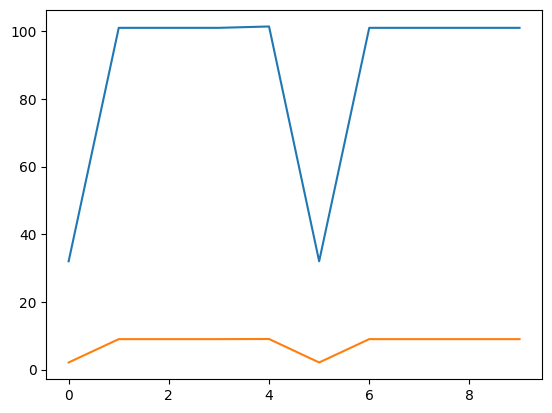

In [6]:
model = NN()
agent = DQNAgent(state_size, action_size, model)
done = False
eval_lens = []
eval_rewards = []
for e in range(n_episodes):
    state = env.reset()[0]
    for time in range(5000):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon}")
            break
    if e % 100 == 0:
        eps_len, eps_reward = eval(env, agent)
        eval_lens.append(eps_len)
        eval_rewards.append(eps_reward)

        if eps_len > 200:
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
plt.plot(eval_lens)
plt.plot(eval_rewards)
plt.show()

All episode lengths: [101, 101, 101, 101, 101]
Average episode length: 101.0


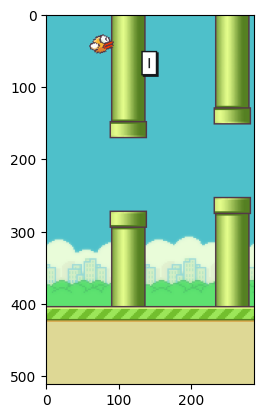

In [7]:
env.reset()
img = plt.imshow(env.render())
episode_lengths = []
for e in range(5):
    state = env.reset()[0]
    done = False
    counter = 0
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        counter += 1
    episode_lengths.append(counter)
print(f"All episode lengths: {episode_lengths}")
print(f"Average episode length: {np.mean(episode_lengths)}")
env.close()